In [ ]:
from torch_geometric.datasets import CitationFull
import pandas as pd
from kgnas.KGNAS import KGNAS
from nas_bench_graph import Arch, light_read
import numpy as np
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Initialize the KGNAS class
# The numerical_weight is the weight of the numerical features in evaluating the dataset similarities, by default it is 0.5. The categorical weight is (1 - numerical_weight).
kgnas = KGNAS()

kgnas.standardize = False
kgnas.activation = 'power'
kgnas.power = 1/3
kgnas.upper_bound = 0.8
kgnas.process_method = 'normal'
kgnas.bound_frac = 0.5
kgnas.set_num_weight(1.0)

In [ ]:
def eval_init_recommendation_global(dataset_name, top_k_dataset, top_k_model, sim_metric, score_metric, sort_by='weighted_score'):
    init_df = kgnas.recommend_model(dataset_name, top_k_dataset=top_k_dataset, top_k_model=top_k_model, sim_metric=sim_metric, score_metric=score_metric, include_target_dataset=False, style='global')

    init_df.sort_values(sort_by, ascending=False, inplace=True)

    arch = init_df.iloc[0]['norm_target_entity']

    # struct_list = [int(i) for i in best_model['has_struct_topology'][1:-1].split(',')]
    # layer_list = [best_model[f'has_struct_{i}'] for i in range(1, 5)]
    bench = light_read(dataset_name)
    
    if arch not in bench.keys():
        for model in init_df.iterrows():
            if model[1]['norm_target_entity'] in bench.keys():
                arch = model[1]['norm_target_entity']
                break
        # return None, None

    info = bench[int(arch)]
    
    return info['perf']

def collect_perf_global(sim_metric, score_metric, sort_by):
    data_names = ['cora', 'citeseer', 'pubmed', 'cs', 'physics', 'photo', 'computers', 'arxiv']

    perf_dict = {name: 0 for name in data_names}
    for name in data_names:
        retrieved_perf = eval_init_recommendation_global(name, 2, 40, sim_metric, score_metric, sort_by)
        perf_dict[name] = str(float(retrieved_perf)*100)[:5]
    print(('\t').join(v for v in perf_dict.values()))
    return perf_dict

def get_scroe_perf_relation(dataset_name, top_k_dataset, top_k_model, sim_metric, score_metric, sort_by='weighted_score'):
    init_df = kgnas.recommend_model(dataset_name, top_k_dataset=top_k_dataset, top_k_model=top_k_model, sim_metric=sim_metric, score_metric=score_metric, include_target_dataset=False, style='global')

    init_df.sort_values(sort_by, ascending=False, inplace=True)

    init_df = init_df.iloc[0:top_k_model]

    # arch = init_df.iloc[0]['norm_target_entity']

    bench = light_read(dataset_name)
    
    # if arch not in bench.keys():
    #     for model in init_df.iterrows():
    #         if model[1]['norm_target_entity'] in bench.keys():
    #             arch = model[1]['norm_target_entity']
    #             break
        # return None, None

    init_df['perf'] = init_df['norm_target_entity'].apply(lambda x: bench[int(x)]['perf'])
    
    return init_df

def get_LR_relation(df, x_key, y_key):
    X = df[x_key].values.reshape(-1, 1)
    y = df[y_key].values

    model = LinearRegression()
    model.fit(X, y)

    y_pred = model.predict(X)

    r_squared = model.score(X, y)
    slope = model.coef_[0]

    return y_pred, r_squared, slope

def eval_score_perf_linearity(sim_metric, score_metric, sort_by='weighted_score'):
    data_names = ['cora', 'citeseer', 'pubmed', 'cs', 'physics', 'photo', 'computers', 'arxiv']

    info_dict = {data: {'slope': [], 'r_squared': []} for data in data_names}

    for data in data_names:
        init_df = get_scroe_perf_relation(data, 2, 15, sim_metric, score_metric, sort_by)
        y_pred, r_squared, slope = get_LR_relation(init_df, 'weighted_score', 'perf')
        info_dict[data]['slope'] = slope
        info_dict[data]['r_squared'] = r_squared
    
    return info_dict

In [ ]:
def plot_scatter_relation(df, x_key='dataset_similarity', y_key='perf'):

    y_pred, r_squared, slope = get_LR_relation(df, x_key, y_key)

    # Scatter plot with linear regression line
    plt.figure(figsize=(10, 6))
    plt.scatter(df[x_key], df[y_key], marker='o', label='Data Points')

    # Plotting the linear regression line
    plt.plot(df[x_key], y_pred, color='red', label='Linear Regression Line')

    # Adding annotations for each point
    for i, txt in enumerate(df.index):
        plt.annotate(txt, (df.loc[txt, x_key], df.loc[txt, y_key]))

    # plt.text(5, 3, f'$R^2 = {r_squared:.2f}$', fontsize=12, color='red', transform=ax.transAxes)
    # plt.text(5, 3.5, f'Slope = {slope:.2f}', fontsize=12, color='blue')

    plt.title(f'Relationship between {x_key} and {y_key} with Linear Regression')
    plt.xlabel(x_key)
    plt.ylabel(y_key)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()

    # Display the plot
    plt.show()

def get_LR_relation(df, x_key, y_key):
    X = df[x_key].values.reshape(-1, 1)
    y = df[y_key].values

    model = LinearRegression()
    model.fit(X, y)

    y_pred = model.predict(X)

    r_squared = model.score(X, y)
    slope = model.coef_[0]

    return y_pred, r_squared, slope

In [ ]:
def get_perf_df(dataset_name, top_k_model, sim_metric, score_metric, sort_by='score'):
    init_df = kgnas.recommend_model(dataset_name, top_k_dataset=9, top_k_model=top_k_model, sim_metric=sim_metric, score_metric=score_metric, include_target_dataset=True)

    candidate_df = init_df[init_df['dataset'] != dataset_name]
    source_df = init_df[init_df['dataset'] == dataset_name].sort_values(by=sort_by, ascending=False)
    
    bench = light_read(dataset_name)

    info_dict = {data: {'perf': [], 'rank': []} for data in ['cora', 'citeseer', 'pubmed', 'cs', 'physics', 'photo', 'computers', 'arxiv']}
    for dataset in ['cora', 'citeseer', 'pubmed', 'cs', 'physics', 'photo', 'computers', 'arxiv']:
        for k in range(top_k_model):
            if dataset != dataset_name:
                if type(sort_by) == list:
                    candidate_df['sorting_metric'] = candidate_df[sort_by].mean(axis=1)
                    best_model = candidate_df[candidate_df['dataset'] == dataset].sort_values(by='sorting_metric', ascending=False).iloc[k]
                else:
                    best_model = candidate_df[candidate_df['dataset'] == dataset].sort_values(by=sort_by, ascending=False).iloc[k]

                struct_list = [int(i) for i in best_model['has_struct_topology'][1:-1].split(',')]
                layer_list = [best_model[f'has_struct_{i}'] for i in range(1, 5)]
                arch = Arch(struct_list, layer_list).valid_hash()

                info_dict[dataset]['perf'].append(bench[arch]['perf'])

            else:
                info_dict[dataset]['perf'].append(source_df['perf'].iloc[k])

    # info_dict_df = pd.DataFrame(info_dict)

    return info_dict

def calculate_mrr(original, computed):
    rank = [original[i] + 1 for i, x in enumerate(computed)]
    mrr = np.mean([1.0/r for r in rank])
    return mrr

In [ ]:
def get_info_df(dataset_name, top_k_dataset, top_k_model, sim_metric, score_metric, sort_by='score', selected_dataset_rank=0):
    dataset_similarities_df = kgnas.get_similar_dataset(dataset_name, top_k=top_k_dataset, sim_metric=sim_metric, include_target_dataset=False)

    source_model_df = kgnas.model_desc.hyper_relation_info.loc[kgnas.model_desc.hyper_relation_info['source_entity'] == dataset_similarities_df.iloc[selected_dataset_rank]['dataset']]
    source_model_df = source_model_df.sort_values(by=sort_by, ascending=False).head(top_k_model)

    target_model_df = kgnas.model_desc.hyper_relation_info.loc[kgnas.model_desc.hyper_relation_info['source_entity'] == dataset_name]
    
    info_dict = {'source_val': [], 'target_val': [], 'source_perf': [], 'target_perf': []}


    for k in range(top_k_model):
        info_dict['source_val'].append(source_model_df.iloc[k][sort_by])
        info_dict['target_val'].append(target_model_df.loc[target_model_df['structure_id'] == source_model_df.iloc[k]['structure_id']][sort_by].values[0])

        info_dict['source_perf'].append(source_model_df.iloc[k]['perf'])
        info_dict['target_perf'].append(target_model_df.loc[target_model_df['structure_id'] == source_model_df.iloc[k]['structure_id']]['perf'].values[0])

    info_df = pd.DataFrame(info_dict)

    return info_df

def eval_error_probability(info_df, epsilon, perf_bar=None):
    info_df['val_diff'] = info_df['source_val'] - info_df['target_val']

    info_df['within_error'] = info_df['val_diff'].apply(lambda x: 1 if x <= epsilon else 0)

    if not perf_bar:
        prob = info_df['within_error'].sum() / len(info_df)
        avg_perf = info_df[info_df['within_error'] == 1]['target_perf'].mean()
    else:
        info_df['within_bar'] = info_df['source_val'].apply(lambda x: 1 if x >= perf_bar else 0)
        info_df['counted'] = info_df['within_bar'] * info_df['within_error']

        prob = info_df['counted'].sum() / info_df['within_bar'].sum()
        avg_perf = info_df[info_df['counted'] == 1]['target_perf'].mean()

    return prob, avg_perf

def calculate_mrr(original, computed):
    rank = [original[i] + 1 for i, x in enumerate(computed)]
    mrr = np.mean([1.0/r for r in rank])
    return mrr

In [6]:
kgnas.standardize = False
kgnas.activation = 'power'
kgnas.power = 1/3
kgnas.upper_bound = 0.8
kgnas.process_method = 'normal'
kgnas.bound_frac = 0.5
kgnas.set_num_weight(1.0)

# info_df = get_info_df('physics', 1, 10, 'gower', 'avg', 'perf_top_diff')
# sim_perf_df = eval_error_probability(info_df, 0.01)
# info_df

In [7]:
prob_dict = {}
perf_dict = {}
for dataset in ['cora', 'citeseer', 'pubmed', 'cs', 'physics', 'photo', 'computers', 'arxiv']:
    prob_dict[dataset] = []
    perf_dict[dataset] = []
    num_models = 500
    info_df = get_info_df(dataset, 1, num_models, 'gower', 'avg', 'perf_top_diff')
    for eps in np.arange(0.01, 0.11, 0.01):
        prob, perf = eval_error_probability(info_df, eps)
        # prob = eval_error_probability(dataset, eps, 1, num_models, 'gower', 'avg', sort_by='perf_top_diff')[1]
        prob_dict[dataset].append(prob)

        # avg_perf = info_df['target_perf'].mean()
        perf_dict[dataset].append(perf)

<Axes: title={'center': 'Error Probability vs Epsilon for Different Datasets'}, xlabel='Epsilon', ylabel='Error Probability'>

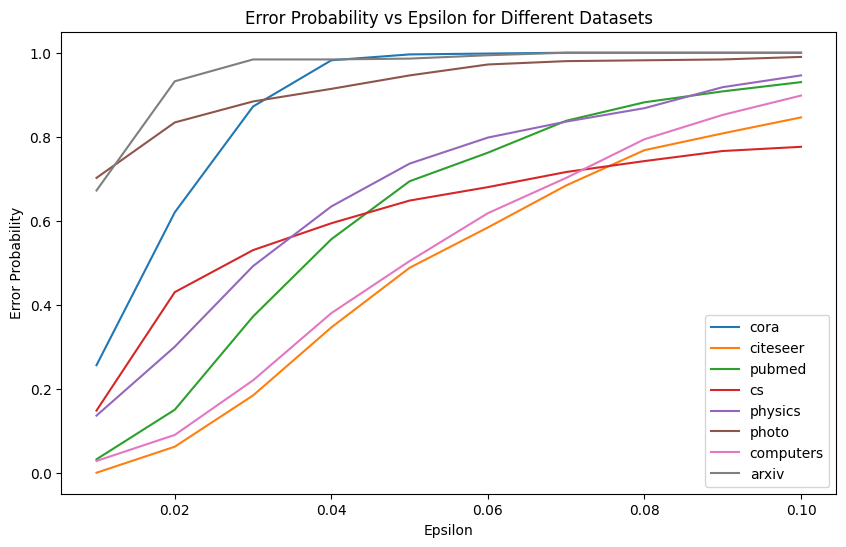

In [8]:
prob_df = pd.DataFrame(prob_dict)
prob_df.set_index(np.arange(0.01, 0.11, 0.01), inplace=True)
prob_df.plot(figsize=(10, 6), title='Error Probability vs Epsilon for Different Datasets', xlabel='Epsilon', ylabel='Error Probability')

<Axes: title={'center': 'Error Probability vs Epsilon for Different Datasets'}, xlabel='Epsilon', ylabel='Error Probability'>

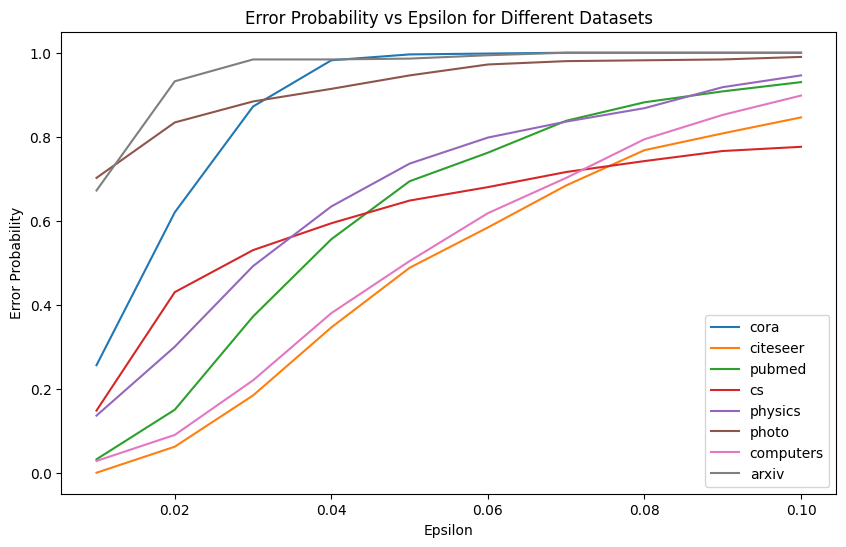

In [9]:
prob_df.plot(figsize=(10, 6), title='Error Probability vs Epsilon for Different Datasets', xlabel='Epsilon', ylabel='Error Probability')

<Axes: title={'center': 'Error Probability vs Epsilon for Different Datasets'}, xlabel='Epsilon', ylabel='Error Probability'>

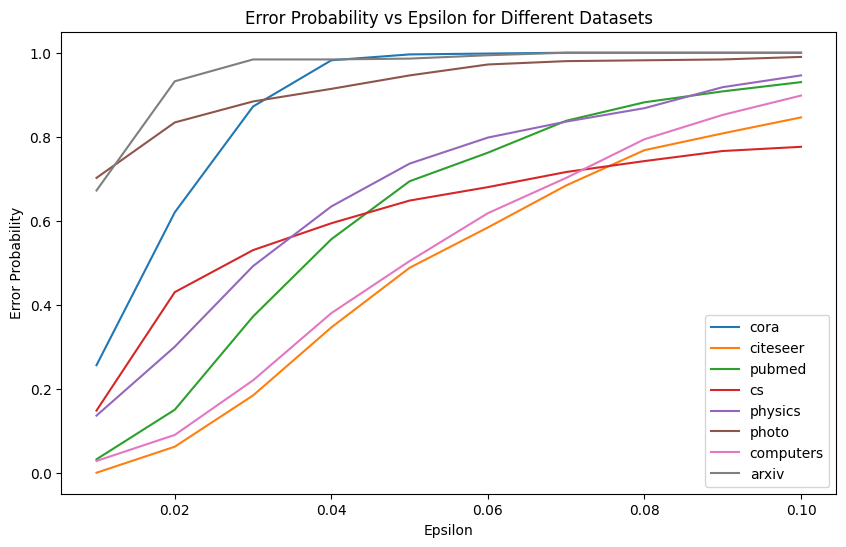

In [10]:
prob_df.plot(figsize=(10, 6), title='Error Probability vs Epsilon for Different Datasets', xlabel='Epsilon', ylabel='Error Probability')

<Axes: title={'center': 'Avg Perf vs Epsilon for Different Datasets'}, xlabel='Epsilon', ylabel='Avg Perf'>

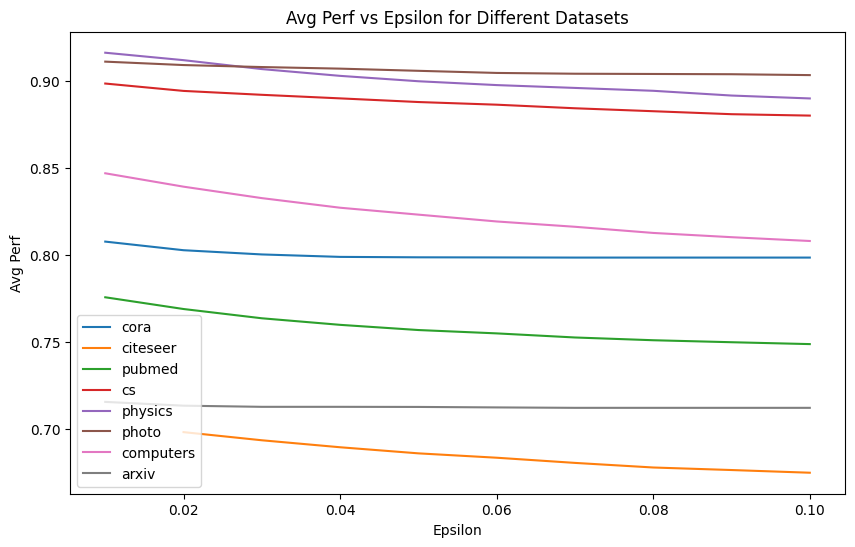

In [11]:
perf_df = pd.DataFrame(perf_dict)
perf_df.set_index(np.arange(0.01, 0.11, 0.01), inplace=True)
perf_df.plot(figsize=(10, 6), title='Avg Perf vs Epsilon for Different Datasets', xlabel='Epsilon', ylabel='Avg Perf')

<Axes: title={'center': 'Avg Perf vs Epsilon for Different Datasets'}, xlabel='Epsilon', ylabel='Avg Perf'>

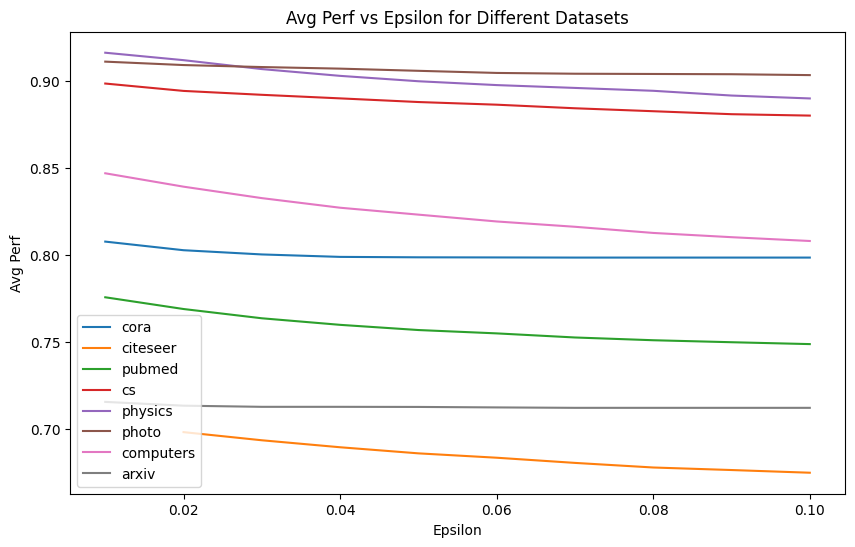

In [12]:
perf_df = pd.DataFrame(perf_dict)
perf_df.set_index(np.arange(0.01, 0.11, 0.01), inplace=True)
perf_df.plot(figsize=(10, 6), title='Avg Perf vs Epsilon for Different Datasets', xlabel='Epsilon', ylabel='Avg Perf')

In [13]:
prob_dict = {}
perf_dict = {}
dataset_name = 'cora'
dataset_similarities_df = kgnas.get_similar_dataset(dataset_name, top_k=8, sim_metric='gower', include_target_dataset=False)
for index in range(0, 8):
    prob_dict[index] = []
    perf_dict[index] = []
    num_models = 500
    info_df = get_info_df(dataset_name, 8, num_models, 'gower', 'avg', 'perf_top_diff', selected_dataset_rank=index)
    for eps in np.arange(0.01, 0.11, 0.01):
        prob, perf = eval_error_probability(info_df, eps)
        # prob = eval_error_probability(dataset, eps, 1, num_models, 'gower', 'avg', sort_by='perf_top_diff')[1]
        prob_dict[index].append(prob)

        # avg_perf = info_df['target_perf'].mean()
        perf_dict[index].append(perf)

In [15]:
prob_dict = {}
perf_dict = {}

dataset = 'physics'
num_models = 5000

info_df = get_info_df(dataset, 1, num_models, 'gower', 'avg', 'perf_top_diff')
for perf_bar in np.arange(0.98, 0.995, 0.003):
    prob_dict[perf_bar] = []
    perf_dict[perf_bar] = []
    for eps in np.arange(0.01, 0.11, 0.01):
        prob, perf = eval_error_probability(info_df, eps, perf_bar=perf_bar)
        # prob = eval_error_probability(dataset, eps, 1, num_models, 'gower', 'avg', sort_by='perf_top_diff')[1]
        prob_dict[perf_bar].append(prob)
        # avg_perf = info_df['target_perf'].mean()
        perf_dict[perf_bar].append(perf)

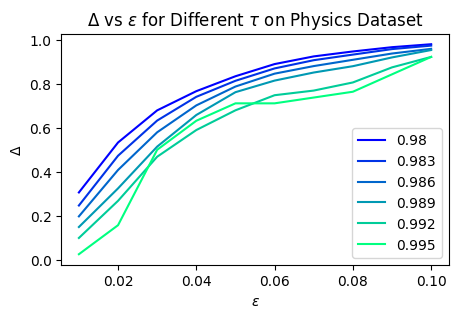

In [16]:
prob_df = pd.DataFrame(prob_dict)
prob_df.set_index(np.arange(0.01, 0.11, 0.01), inplace=True)

# Normalize the label values
labels = prob_df.columns
normalized_labels = (labels - labels.min()) / (labels.max() - labels.min())

# Use a colormap (e.g., 'viridis') to map normalized values to colors
colormap = plt.cm.winter

# Plot each line with the corresponding color
plt.figure(figsize=(5, 3))
for label, norm_label in zip(labels, normalized_labels):
    plt.plot(prob_df.index, prob_df[label], label=label, color=colormap(norm_label))

plt.title(r'$\Delta$ vs $\epsilon$ for Different $\tau$ on Physics Dataset')
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$\Delta$')
plt.legend()
plt.show()

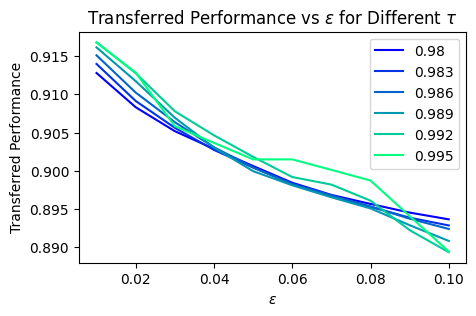

In [17]:
perf_df = pd.DataFrame(perf_dict)
perf_df.set_index(np.arange(0.01, 0.11, 0.01), inplace=True)

# Normalize the label values
labels = perf_df.columns
normalized_labels = (labels - labels.min()) / (labels.max() - labels.min())

# Use a colormap (e.g., 'viridis') to map normalized values to colors
colormap = plt.cm.winter

# Plot each line with the corresponding color
plt.figure(figsize=(5, 3))
for label, norm_label in zip(labels, normalized_labels):
    plt.plot(perf_df.index, perf_df[label], label=label, color=colormap(norm_label))

plt.title(r'Transferred Performance vs $\epsilon$ for Different $\tau$')
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'Transferred Performance')
plt.legend()
plt.show()

In [ ]:
prob_dict = {}
perf_dict = {}

# dataset = 'physics'
num_models = 5000

for dataset in ['cora', 'citeseer', 'pubmed', 'cs', 'physics', 'photo', 'computers', 'arxiv']:
    info_df = get_info_df(dataset, 1, num_models, 'gower', 'avg', 'perf_top_diff')
    perf_bar = 0.99
    # for perf_bar in np.arange(0.98, 0.995, 0.003):
    prob_dict[dataset] = []
    perf_dict[dataset] = []
    for eps in np.arange(0.01, 0.11, 0.01):
        prob, perf = eval_error_probability(info_df, eps, perf_bar=perf_bar)
        # prob = eval_error_probability(dataset, eps, 1, num_models, 'gower', 'avg', sort_by='perf_top_diff')[1]
        prob_dict[dataset].append(prob)
        # avg_perf = info_df['target_perf'].mean()
        perf_dict[dataset].append(perf)

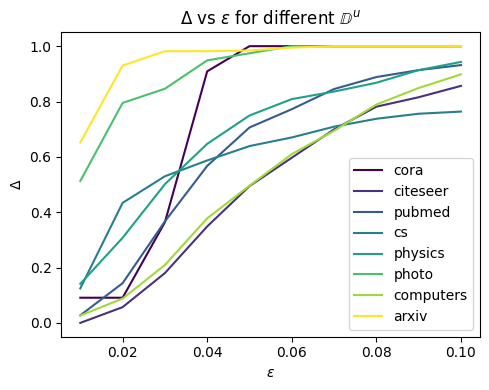

In [30]:
prob_df = pd.DataFrame(prob_dict)
prob_df.set_index(np.arange(0.01, 0.11, 0.01), inplace=True)

# Normalize the label values
# labels = prob_df.columns
# normalized_labels = (labels - labels.min()) / (labels.max() - labels.min())

normalized_labels = np.array(list(range(len(prob_df.columns)))) / (len(prob_df.columns) - 1)

# Use a colormap (e.g., 'viridis') to map normalized values to colors
colormap = plt.cm.viridis

# Plot each line with the corresponding color
plt.figure(figsize=(5, 4))
for label, norm_label in zip(labels, normalized_labels):
# for label in prob_df.columns:
    plt.plot(prob_df.index, prob_df[label], label=label, color=colormap(norm_label))

plt.title(r'$\Delta$ vs $\epsilon$ for different $\mathbb{D}^u$')
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$\Delta$')
plt.legend()
plt.tight_layout()
plt.savefig('figures/error_prob_vs_epsilon.pdf')
plt.show()

In [ ]:
def plot_subplots(source_datasets, num_models, perf_bar):
    fig, axs = plt.subplots(1, len(source_datasets), figsize=(12, 3))
    colormap = plt.cm.winter

    for i, source_dataset in enumerate(source_datasets):
        prob_dict = {}
        perf_dict = {}

        dataset_similarities_df = kgnas.get_similar_dataset(source_dataset, top_k=4, sim_metric='gower', include_target_dataset=False)

        for index in range(4):
            info_df = get_info_df(source_dataset, 4, num_models, 'gower', 'avg', 'perf_top_diff', selected_dataset_rank=index)
        
            prob_dict[index] = []
            perf_dict[index] = []

            for eps in np.arange(0.01, 0.11, 0.01):
                prob, perf = eval_error_probability(info_df, eps, perf_bar=perf_bar)
                prob_dict[index].append(prob)
                perf_dict[index].append(perf)

        prob_df = pd.DataFrame(prob_dict)
        prob_df.set_index(np.arange(0.01, 0.11, 0.01), inplace=True)

        perf_df = pd.DataFrame(perf_dict)
        perf_df.set_index(np.arange(0.01, 0.11, 0.01), inplace=True)

        labels = prob_df.columns
        normalized_labels = (labels - labels.min()) / (labels.max() - labels.min())

        for label, norm_label in zip(labels, normalized_labels):
            dataset, similarity = dataset_similarities_df.iloc[label]['dataset'], dataset_similarities_df.iloc[label]['dataset_similarity']
            axs[i].plot(prob_df.index, prob_df[label], label=f'{dataset}-{similarity:.4f}', color=colormap(norm_label))

        # axs[i].plot(prob_df.index, prob_df)
        axs[i].set_title(f'{source_dataset}')
        axs[i].set_xlabel(r'$\epsilon$')
        axs[i].set_ylabel(r'$\Delta$')
        axs[i].set_ylim(0, 1.05)
        axs[i].legend()
        
    plt.tight_layout()
    plt.savefig('figures/dataset_similarity_subplots.pdf')
    plt.show()

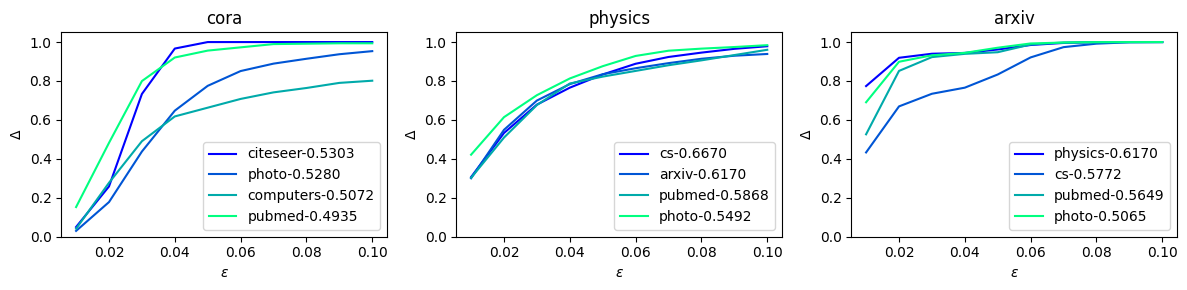

In [ ]:
source_datasets = ['cora', 'physics', 'arxiv']
plot_subplots(source_datasets, 5000, 0.98)

In [12]:
def plot_tau_prob_subplots(source_datasets, num_models, perf_range):
    fig, axs = plt.subplots(1, len(source_datasets), figsize=(12, 3))
    colormap = plt.cm.winter

    for i, source_dataset in enumerate(source_datasets):
        prob_dict = {}
        perf_dict = {}
        
        info_df = get_info_df(source_dataset, 1, num_models, 'gower', 'avg', 'perf_top_diff')

        for index in perf_range:
            prob_dict[index] = []
            perf_dict[index] = []

            for eps in np.arange(0.01, 0.11, 0.01):
                prob, perf = eval_error_probability(info_df, eps, perf_bar=index)
                prob_dict[index].append(prob)
                perf_dict[index].append(perf)

        prob_df = pd.DataFrame(prob_dict)
        prob_df.set_index(np.arange(0.01, 0.11, 0.01), inplace=True)

        perf_df = pd.DataFrame(perf_dict)
        perf_df.set_index(np.arange(0.01, 0.11, 0.01), inplace=True)

        labels = prob_df.columns
        normalized_labels = (labels - labels.min()) / (labels.max() - labels.min())

        for label, norm_label in zip(labels, normalized_labels):
            # dataset, similarity = dataset_similarities_df.iloc[label]['dataset'], dataset_similarities_df.iloc[label]['dataset_similarity']
            axs[i].plot(prob_df.index, prob_df[label], label=r'$\tau$='+f'{label:.3f}', color=colormap(norm_label))


        # axs[i].plot(prob_df.index, prob_df)
        axs[i].set_title(f'{source_dataset}')
        axs[i].set_xlabel(r'$\epsilon$')
        axs[i].set_ylabel(r'$\Delta$')
        axs[i].legend()
        axs[i].set_ylim(0, 1.05)
        
    plt.tight_layout()
    plt.savefig('figures/tau_prob_subplots.pdf')
    plt.show()

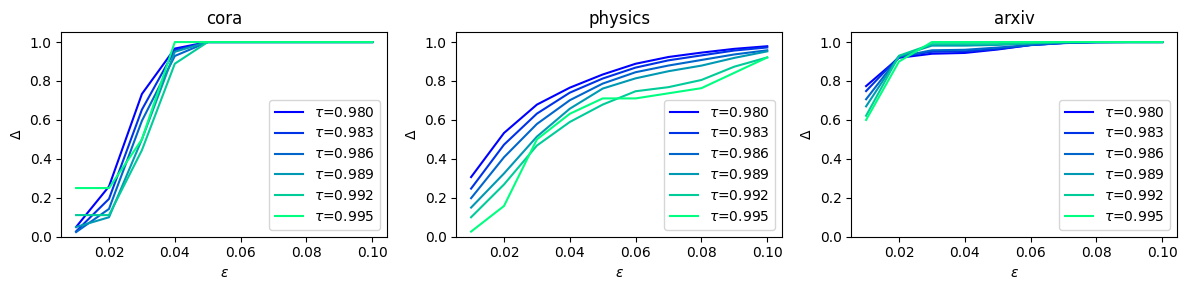

In [13]:
source_datasets = ['cora', 'physics', 'arxiv']
perf_range = np.arange(0.98, 0.995, 0.003)
plot_tau_prob_subplots(source_datasets, 5000, perf_range)

In [14]:
def plot_tau_perf_subplots(source_datasets, num_models, perf_range):
    fig, axs = plt.subplots(1, len(source_datasets), figsize=(12, 3))
    colormap = plt.cm.winter

    for i, source_dataset in enumerate(source_datasets):
        prob_dict = {}
        perf_dict = {}
        
        info_df = get_info_df(source_dataset, 1, num_models, 'gower', 'avg', 'perf_top_diff')

        for index in perf_range:
            prob_dict[index] = []
            perf_dict[index] = []

            for eps in np.arange(0.01, 0.11, 0.01):
                prob, perf = eval_error_probability(info_df, eps, perf_bar=index)
                prob_dict[index].append(prob)
                perf_dict[index].append(perf)

        prob_df = pd.DataFrame(prob_dict)
        prob_df.set_index(np.arange(0.01, 0.11, 0.01), inplace=True)

        perf_df = pd.DataFrame(perf_dict)
        perf_df.set_index(np.arange(0.01, 0.11, 0.01), inplace=True)

        labels = perf_df.columns
        normalized_labels = (labels - labels.min()) / (labels.max() - labels.min())

        for label, norm_label in zip(labels, normalized_labels):
            # dataset, similarity = dataset_similarities_df.iloc[label]['dataset'], dataset_similarities_df.iloc[label]['dataset_similarity']
            axs[i].plot(perf_df.index, perf_df[label], label=r'$\tau$='+f'{label:.3f}', color=colormap(norm_label))


        # axs[i].plot(prob_df.index, prob_df)
        axs[i].set_title(f'{source_dataset}')
        axs[i].set_xlabel(r'$\epsilon$')
        axs[i].set_ylabel(r'$\Delta$')
        axs[i].legend()
        # axs[i].set_ylim(0.80, 1.05)
    
    plt.tight_layout()
    plt.savefig('figures/tau_perf_subplots.pdf')
    plt.show()

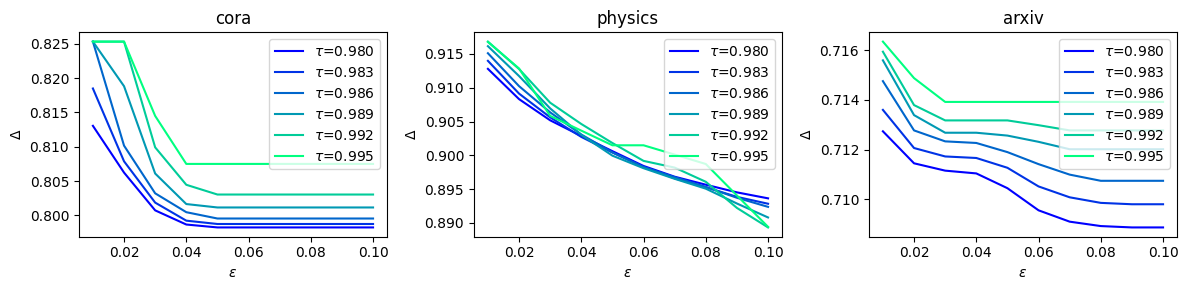

In [15]:
source_datasets = ['cora', 'physics', 'arxiv']
perf_range = np.arange(0.98, 0.995, 0.003)
plot_tau_perf_subplots(source_datasets, 5000, perf_range)

In [5]:
def plot_scatter_relation(df, x_key='dataset_similarity', y_key='area', dataset_name='cora', ax=None):

    y_pred, r_squared, slope = get_LR_relation(df, x_key, y_key)

    # Scatter plot with linear regression line
    if ax is None:
        plt.figure(figsize=(10, 6))
        plt.scatter(df[x_key], df[y_key], color='tab:blue', marker='o', label='Data Points')

        # Plotting the linear regression line
        plt.plot(df[x_key], y_pred, color='tab:cyan', label='Linear Regression Line')

        # Adding annotations for each point
        for i, txt in enumerate(df.index):
            plt.annotate(txt, (df.loc[txt, x_key], df.loc[txt, y_key]))

        # plt.text(5, 3, f'$R^2 = {r_squared:.2f}$', fontsize=12, color='red', transform=ax.transAxes)
        # plt.text(5, 3.5, f'Slope = {slope:.2f}', fontsize=12, color='blue')

        plt.title(f'Relationship between {x_key} and {y_key} with Linear Regression')
        plt.xlabel(x_key)
        plt.ylabel(y_key)
        plt.legend()
        plt.grid(True)

        plt.tight_layout()

        # Display the plot
        plt.show()
    
    else:
        ax.scatter(df[x_key], df[y_key], marker='o', color='tab:blue')

        # Plotting the linear regression line
        ax.plot(df[x_key], y_pred, color='tab:cyan')

        # Adding annotations for each point
        for i, txt in enumerate(df.index):
            ax.annotate(txt, (df.loc[txt, x_key], df.loc[txt, y_key]))

        ax.set_title(f'{dataset_name} - Slope={slope:.3f}, ' + r'$R^2$' + f'={r_squared:.3f}')
        ax.set_xlabel(x_key)
        ax.set_ylabel(y_key)
        # ax.legend()
        ax.grid(True)

def get_LR_relation(df, x_key, y_key):
    X = df[x_key].values.reshape(-1, 1)
    y = df[y_key].values

    model = LinearRegression()
    model.fit(X, y)

    y_pred = model.predict(X)

    r_squared = model.score(X, y)
    slope = model.coef_[0]

    return y_pred, r_squared, slope

In [7]:
prob_dict = {}
perf_dict = {}

source_dataset = 'arxiv'
num_models = 5000
top_k_dataset = 3

dataset_similarities_df = kgnas.get_similar_dataset(source_dataset, top_k=top_k_dataset, sim_metric='gower', include_target_dataset=False)
dataset_similarities_df.reset_index(inplace=True)

area_dict = []
# for dataset in ['cora', 'citeseer', 'pubmed', 'cs', 'physics', 'photo', 'computers', 'arxiv']:
for i in range(top_k_dataset):
    info_df = get_info_df(source_dataset, top_k_dataset, num_models, 'gower', 'avg', 'perf_top_diff', selected_dataset_rank=i)
    perf_bar = 0.99
    # for perf_bar in np.arange(0.98, 0.995, 0.003):
    prob_dict[i] = []
    perf_dict[i] = []
    for eps in np.arange(0.01, 0.11, 0.01):
        prob, perf = eval_error_probability(info_df, eps, perf_bar=perf_bar)
        # prob = eval_error_probability(dataset, eps, 1, num_models, 'gower', 'avg', sort_by='perf_top_diff')[1]
        prob_dict[i].append(prob)
        # avg_perf = info_df['target_perf'].mean()
        perf_dict[i].append(perf)

    area = np.mean(list(prob_dict[i]))
    area_dict.append(area)

area_df = pd.DataFrame(area_dict)

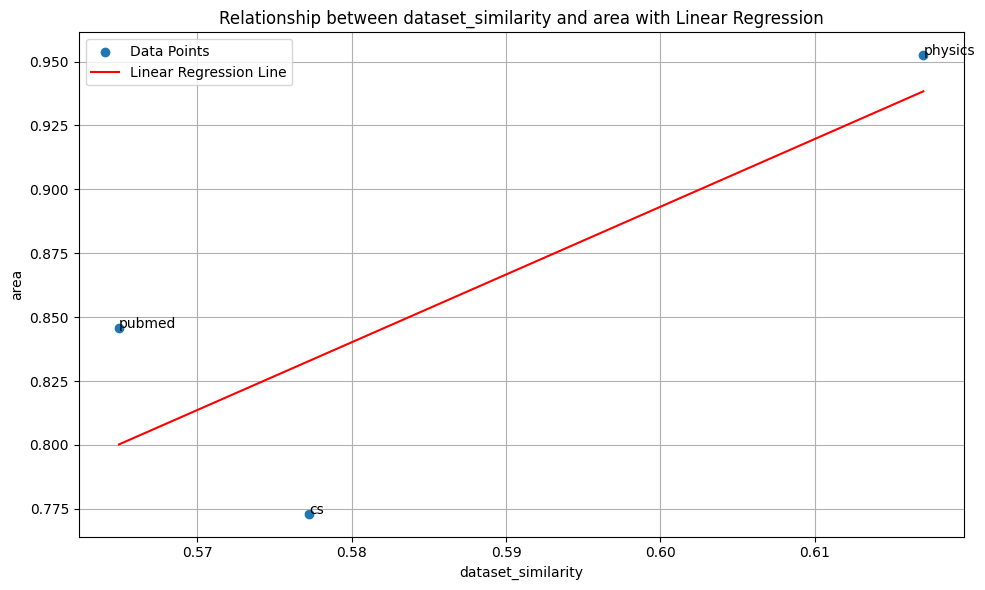

In [8]:
plot_df = dataset_similarities_df.copy()
plot_df['area'] = area_df

plot_df.set_index('dataset', inplace=True)

plot_scatter_relation(plot_df, 'dataset_similarity', 'area')

In [ ]:
num_transferred_model = 20

for i in range(top_k_dataset):
    info_df = get_info_df(source_dataset, 1, num_transferred_model, 'gower', 'avg', 'perf_top_diff', selected_dataset_rank=i)
    

In [10]:
corr_df = {'dataset': [], 'slope': [], 'R_2': [], 'perf': []}

# for dataset in ['cora', 'citeseer', 'pubmed', 'cs', 'physics', 'photo', 'computers', 'arxiv', 'proteins']:
    # sim_perf_df = recommend_with_all(dataset, 10, 'gower', 'avg', sort_by='score')
y_pred, r_squared, slope = get_LR_relation(plot_df, x_key='dataset_similarity', y_key='area')
corr_df['dataset'].append(source_dataset)
corr_df['slope'].append(slope)
corr_df['R_2'].append(r_squared)
corr_df['perf'].append()

corr_df = pd.DataFrame(corr_df)
corr_df

,dataset,slope,R_2
0,arxiv,2.65086,0.640677


In [24]:
def plot_linearity(source_datasets, num_models, top_k_dataset=3):
    fig, axs = plt.subplots(1, len(source_datasets), figsize=(12, 3))

    for ds_idx, source_dataset in enumerate(source_datasets):
        prob_dict = {}
        perf_dict = {}

        # source_dataset = 'arxiv'
        # num_models = 5000
        # top_k_dataset = 3

        dataset_similarities_df = kgnas.get_similar_dataset(source_dataset, top_k=top_k_dataset, sim_metric='gower', include_target_dataset=False)
        dataset_similarities_df.reset_index(inplace=True)

        area_dict = []
        # for dataset in ['cora', 'citeseer', 'pubmed', 'cs', 'physics', 'photo', 'computers', 'arxiv']:
        for i in range(top_k_dataset):
            info_df = get_info_df(source_dataset, top_k_dataset, num_models, 'gower', 'avg', 'perf_top_diff', selected_dataset_rank=i)
            perf_bar = 0.99
            # for perf_bar in np.arange(0.98, 0.995, 0.003):
            prob_dict[i] = []
            perf_dict[i] = []
            for eps in np.arange(0.01, 0.11, 0.01):
                prob, perf = eval_error_probability(info_df, eps, perf_bar=perf_bar)
                # prob = eval_error_probability(dataset, eps, 1, num_models, 'gower', 'avg', sort_by='perf_top_diff')[1]
                prob_dict[i].append(prob)
                # avg_perf = info_df['target_perf'].mean()
                perf_dict[i].append(perf)

            area = np.mean(list(prob_dict[i]))
            area_dict.append(area)

        area_df = pd.DataFrame(area_dict)

        plot_df = dataset_similarities_df.copy()
        plot_df['area'] = area_df

        plot_df.set_index('dataset', inplace=True)

        plot_scatter_relation(plot_df, 'dataset_similarity', 'area', source_dataset, axs[ds_idx])

    
    plt.tight_layout()
    plt.show()

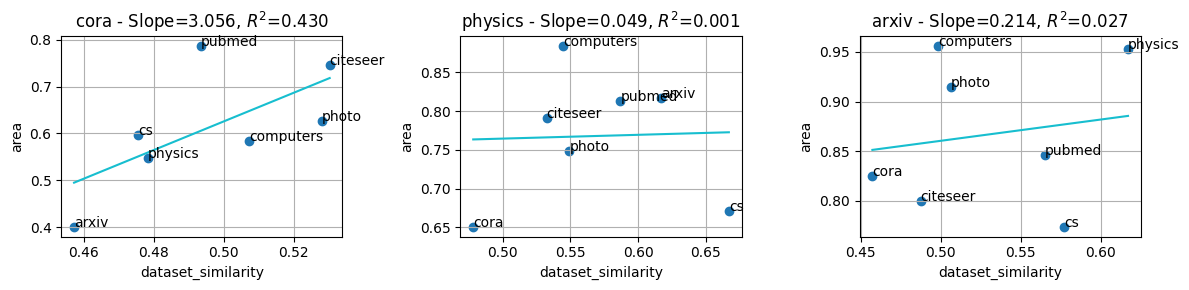

In [28]:
plot_linearity(['cora', 'physics', 'arxiv'], 5000, 7)

In [7]:
def calc_linearity(source_datasets, num_models, top_k_dataset=7, sim_metric='gower'):
    info_dict = {'name': [], 'performance': [], 'R^2': []}
    for ds_idx, source_dataset in enumerate(source_datasets):
        prob_dict = {}
        perf_dict = {}

        dataset_similarities_df = kgnas.get_similar_dataset(source_dataset, top_k=top_k_dataset, sim_metric=sim_metric, include_target_dataset=False)
        dataset_similarities_df.reset_index(inplace=True)

        area_dict = []
        # for dataset in ['cora', 'citeseer', 'pubmed', 'cs', 'physics', 'photo', 'computers', 'arxiv']:
        for i in range(top_k_dataset):
            info_df = get_info_df(source_dataset, top_k_dataset, num_models, sim_metric, 'avg', 'perf_top_diff', selected_dataset_rank=i)
            perf_bar = 0.99
            # for perf_bar in np.arange(0.98, 0.995, 0.003):
            prob_dict[i] = []
            perf_dict[i] = []
            for eps in np.arange(0.01, 0.11, 0.01):
                prob, perf = eval_error_probability(info_df, eps, perf_bar=perf_bar)
                # prob = eval_error_probability(dataset, eps, 1, num_models, 'gower', 'avg', sort_by='perf_top_diff')[1]
                prob_dict[i].append(prob)
                # avg_perf = info_df['target_perf'].mean()
                perf_dict[i].append(perf)

            area = np.mean(list(prob_dict[i]))
            area_dict.append(area)

        area_df = pd.DataFrame(area_dict)

        plot_df = dataset_similarities_df.copy()
        plot_df['area'] = area_df

        plot_df.set_index('dataset', inplace=True)

        y_pred, r_squared, slope = get_LR_relation(plot_df, 'dataset_similarity', 'area')

        info_dict['name'].append(source_dataset)
        info_dict['performance'].append(perf_dict[0][-1])
        info_dict['R^2'].append(r_squared)

    info_df = pd.DataFrame(info_dict)
    return info_df

In [7]:
kgnas.standardize = False
kgnas.activation = 'power'
kgnas.power = 1/3
kgnas.upper_bound = 0.8
kgnas.process_method = 'normal'
kgnas.bound_frac = 0.5
kgnas.set_num_weight(1.0)

In [14]:
info_df = calc_linearity(['cora', 'physics', 'arxiv'], 10, 7)

In [9]:
weight_records = []
for num_weight in np.arange(0.1, 1.1, 0.1):
    kgnas.set_num_weight(num_weight)
    info_df = calc_linearity(['cora', 'physics', 'arxiv'], 1000, 7)
    info_df['num_weight'] = num_weight
    weight_records.append(info_df)

weight_df = pd.concat(weight_records)

Given the R^2 value of different metrics, we can not consider how to compare different metrics, L1, L2, Cosine, Etc..

As well as study whether the categorical values are meaningful to the dataset similarity measurement. 

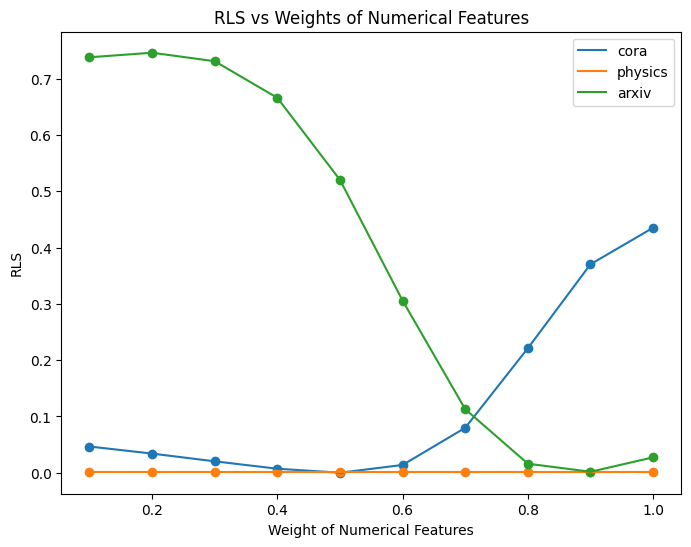

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))

for name in weight_df['name'].unique():
    df = weight_df[weight_df['name'] == name]
    ax.plot(df['num_weight'], df['R^2'], label=name)
    ax.scatter(df['num_weight'], df['R^2'])  # Add scatter points

ax.set_xlabel('Weight of Numerical Features')
ax.set_ylabel('RLS')
ax.set_title('RLS vs Weights of Numerical Features')
ax.legend()

plt.savefig('figures/RLS_vs_num_weights.pdf')
plt.show()

In [8]:
kgnas.set_num_weight(1)
weight_records = []
for sim_metric in ['gower', 'cosine', 'l2', 'l1']:
    info_df = calc_linearity(['cora', 'physics', 'arxiv'], 10, 7, sim_metric)
    info_df['sim_metric'] = sim_metric
    weight_records.append(info_df)

metric_weight_df = pd.concat(weight_records)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

for name in metric_weight_df['name'].unique():
    df = metric_weight_df[metric_weight_df['name'] == name]
    ax.plot(df['num_weight'], df['R^2'], label=name)
    ax.scatter(df['num_weight'], df['R^2'])  # Add scatter points

ax.set_xlabel('num_weight')
ax.set_ylabel('R^2')
ax.set_title('R^2 vs num_weight')
ax.legend()

plt.show()

In [ ]:
pivot_df = df.pivot(index='sim_metric', columns='name', values='R^2')

print(pivot_df)